# Acá hacemos oversampling con SMOTE y entrenamos de vuelta

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTE

import shap

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, f1_score, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns

import logging
import sys

import joblib


In [2]:
# Configurar logging para LightGBM
sys.stdout = open('logs/lightgbm_output_nro6.txt', 'w')
sys.stderr = open('logs/lightgbm_output_nro6.txt', 'a')

In [3]:
logging.basicConfig(filename='logs/lgbm_sexto_model.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', filemode='w')


### Cargamos los datos autofeatureados

In [4]:
logging.info("Cargando datos...")
df = pd.read_parquet('data\df_filtered.parquet')

In [5]:
df.columns

Index(['WS10M', 'SQ1', 'T2M * TS', 'elevation * T2MDEW', 'SQ4', 'CULT_LAND',
       'fips', 'elevation * WS50M', 'QV2M * WS10M', 'lon', 'month',
       'T2M_RANGE', 'TS * WS10M', 'FOR_LAND', 'year', 'GRS_LAND',
       'elevation * PRECTOT', 'PRECTOT * TS', 'slope2', 'aspectN', 'SQ7',
       'SQ5', 'lat', 'NVG_LAND', 'PRECTOT + T2M', 'PS + WS50M', 'aspectS',
       'WS50M_RANGE', 'day', 'slope7', 'PS * TS', 'aspectE', 'WS10M_RANGE',
       'elevation * TS', 'URB_LAND', 'score_final_interpolated'],
      dtype='object')

In [6]:
df.shape

(1644000, 36)

In [7]:
df.score_final_interpolated.value_counts()

score_final_interpolated
0.0    1075750
1.0     269027
2.0     147296
3.0      84748
4.0      47971
5.0      19208
Name: count, dtype: int64

In [8]:
# Reemplazar las clases 4 y 5 por la clase 3 en la columna 'score_final_interpolated'
df['score_final_interpolated'] = df['score_final_interpolated'].replace({4: 3, 5: 3})

In [9]:
df.score_final_interpolated.value_counts()

score_final_interpolated
0.0    1075750
1.0     269027
3.0     151927
2.0     147296
Name: count, dtype: int64

In [10]:
df["date"] = pd.to_datetime(df[["year", "month", "day"]])

In [11]:
# vemos el valor de la fecha menor y mayor
df.date.min(), df.date.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [12]:
X = df.drop(columns=['score_final_interpolated'])
y = df['score_final_interpolated']

In [13]:
# Fecha de corte.
cutoff_date = pd.Timestamp('2019-01-01')

In [14]:
# Separar los datos de entrenamiento (antes de 2019) y prueba (desde 2019)
train_mask = df['date'] < cutoff_date
test_mask = df['date'] >= cutoff_date

In [15]:
# Crear conjuntos de entrenamiento y prueba
X_train = df.loc[train_mask].drop(columns=['score_final_interpolated', 'date'])
y_train = df.loc[train_mask]['score_final_interpolated']


In [16]:
X_test = df.loc[test_mask].drop(columns=['score_final_interpolated', 'date'])
y_test = df.loc[test_mask]['score_final_interpolated']

In [17]:
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

In [18]:
print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

In [19]:
# Aplicar SMOTE para oversampling de las clases minoritarias en el conjunto de entrenamiento
smote = SMOTE(random_state=75382)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

logging.info("SMOTE aplicado. Clases equilibradas en el conjunto de entrenamiento.")

In [20]:
print("Distribución después de SMOTE:")
print(y_train_smote.value_counts())

## Optimizar la métrica que quieras, pero average = weighted. no como el primer intento que hice.

In [21]:
def bayesian_opt_lgbm(X, y, init_iter=5, n_iters=10, random_state=666, seed=101, num_iterations=200):
    tscv = TimeSeriesSplit(n_splits=5)  # Definir TimeSeriesSplit
    dtrain = lgb.Dataset(data=X, label=y)

    # Ajustar para clasificación multiclase con f1_score ponderado
    def lgb_f1_score(preds, dtrain):
        labels = dtrain.get_label()
        preds = preds.reshape(len(np.unique(y)), -1).argmax(axis=0)  # Convertir las probabilidades en predicciones de clases
        score = f1_score(labels, preds, average='weighted')  # Ponderado para manejar el desbalance de clases
        return 'custom_f1', score, True  # Nombre de la métrica personalizado

    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
        logging.info(f"Probando parámetros: num_leaves={num_leaves}, feature_fraction={feature_fraction}, bagging_fraction={bagging_fraction}, max_depth={max_depth},\
                    min_split_gain={min_split_gain}, min_child_weight={min_child_weight}")
        
        params = {
            'objective': 'multiclass',  # Ajustar a multiclass
            'num_class': len(np.unique(y)),  # Número de clases
            'num_iterations': num_iterations,
            'learning_rate': 0.05,
            'early_stopping_round': 50,
            'metric': 'None',  # No usar métrica predeterminada
        }
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight

        # Usamos feval para definir la métrica personalizada (f1_score ponderado)
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed, stratified=False,
                            feval=lgb_f1_score, folds=tscv, shuffle=False)

        # Verificar las claves disponibles en cv_results y escribirlas en el log
        logging.info(f"Resultados de cv: {cv_results.keys()}")

        # Ajustar a la métrica correcta
        score = np.max(cv_results['valid custom_f1-mean'])  # Acceder a la métrica correcta
        logging.info(f"Parámetros evaluados con F1 ponderado promedio: {score}")
        
        return score

    pds = {
        'num_leaves': (80, 100),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (17, 25),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (10, 25)
    }

    logging.info("Iniciando optimización bayesiana...")
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    logging.info("Optimización bayesiana completada.")

    return optimizer

In [22]:
# Ejecutar la optimización bayesiana con TimeSeriesSplit
opt_result = bayesian_opt_lgbm(X_train_smote, y_train_smote, init_iter=5, n_iters=10, random_state=202410, seed=649792, num_iterations=200)

In [23]:
# Entrenar el mejor modelo encontrado
best_params = opt_result.max['params']
best_params['num_leaves'] = int(round(best_params['num_leaves']))
best_params['max_depth'] = int(round(best_params['max_depth']))
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(np.unique(y_train))  # Número de clases
best_params['metric'] = 'multi_logloss'  # Usar una métrica compatible con multiclase

logging.info(f"Mejores parámetros encontrados: {best_params}")

In [24]:
best_params

{'bagging_fraction': 0.9089493179526446,
 'feature_fraction': 0.8445059004982389,
 'max_depth': 17,
 'min_child_weight': 11.728001864996813,
 'min_split_gain': 0.023577505367936433,
 'num_leaves': 92,
 'objective': 'multiclass',
 'num_class': 4,
 'metric': 'multi_logloss'}

In [25]:
# Crear el modelo utilizando los mejores parámetros
lgbm_best = lgb.LGBMClassifier(
    **best_params,
    class_weight='balanced'  # Para manejar el desbalance
)

# Entrenar el modelo
lgbm_best.fit(X_train_smote, y_train_smote)
logging.info("Entrenamiento del modelo completado.")

In [26]:
# Reconstruir la columna 'date' a partir de 'year', 'month' y 'day'
X_test['date'] = pd.to_datetime(X_test[['year', 'month', 'day']])

# Asegurarnos de que 'fips' es el identificador del sitio
# Combinar X_test con y_test para poder filtrar fácilmente
X_test['score_final_interpolated'] = y_test

# Ordenar por 'fips' y 'date' para garantizar que los registros estén en orden temporal
X_test_sorted = X_test.sort_values(by=['fips', 'date'])

# Filtrar solo los próximos 30 días por cada sitio 'fips'
X_test_30_days = X_test_sorted.groupby('fips').head(30)

# Separar las características y el target de nuevo
y_test_30_days = X_test_30_days['score_final_interpolated']
X_test_30_days = X_test_30_days.drop(columns=['score_final_interpolated', 'date'])  # Eliminamos también la columna 'date'

# Predecir solo para los próximos 30 días por cada sitio
y_pred_30_days = lgbm_best.predict(X_test_30_days)
y_prob_30_days = lgbm_best.predict_proba(X_test_30_days)

# Imprimir los resultados
print("Predicciones para los próximos 30 días por cada sitio:")
print(y_pred_30_days)

In [27]:
# También puedes evaluar el modelo en esos 30 días por sitio
print("Reporte de clasificación para los próximos 30 días por sitio:")
print(classification_report(y_test_30_days, y_pred_30_days))

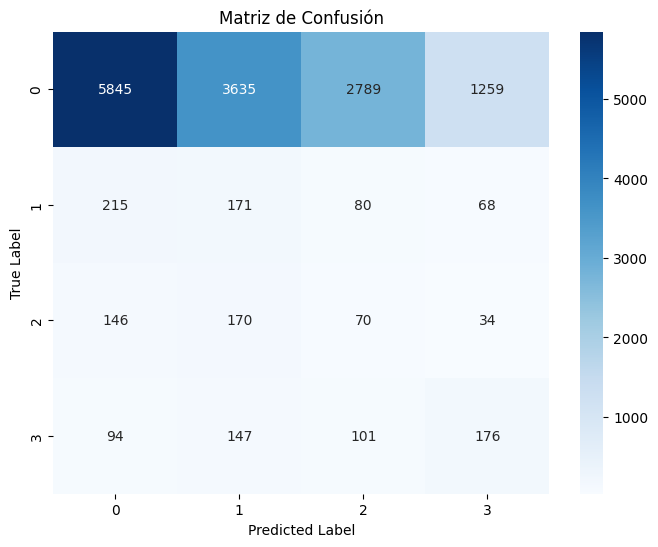

In [28]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_30_days, y_pred_30_days)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


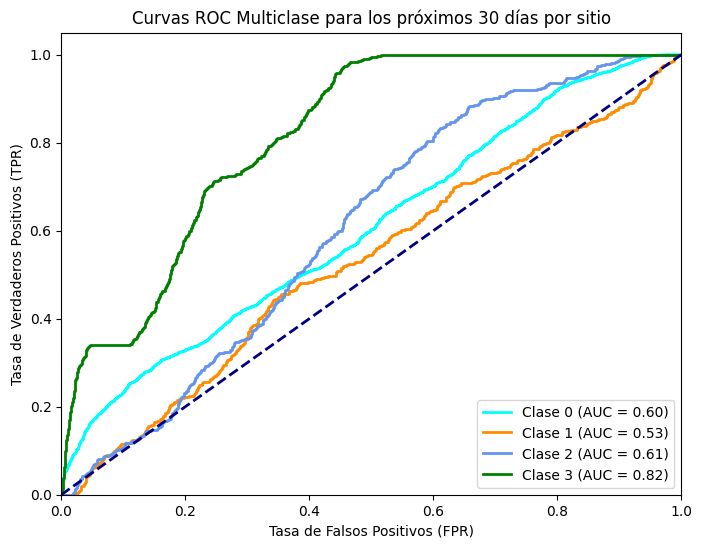

In [29]:
# Binarizar las etiquetas de prueba para calcular la curva ROC multiclase
n_classes = len(np.unique(y_test_30_days))  # Número de clases
y_test_bin = label_binarize(y_test_30_days, classes=np.arange(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular curvas ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_30_days[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC para cada clase
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'red']  # Asignar colores a cada clase

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Gráfica ROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase para los próximos 30 días por sitio')
plt.legend(loc="lower right")
plt.show()

In [31]:
# Crear un explainer SHAP para LightGBM
explainer = shap.Explainer(lgbm_best.predict, X_test_30_days)

In [32]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_30_days)

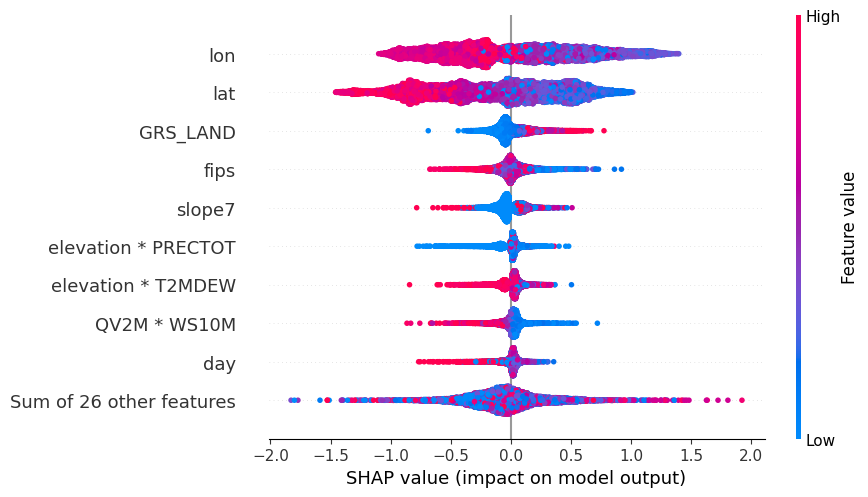

In [33]:
shap.plots.beeswarm(shap_values)

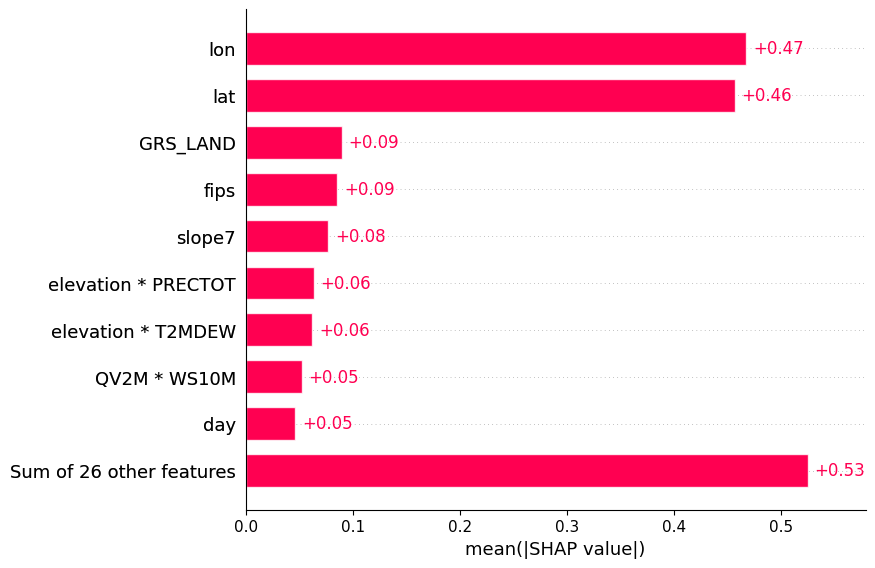

In [34]:
shap.plots.bar(shap_values)


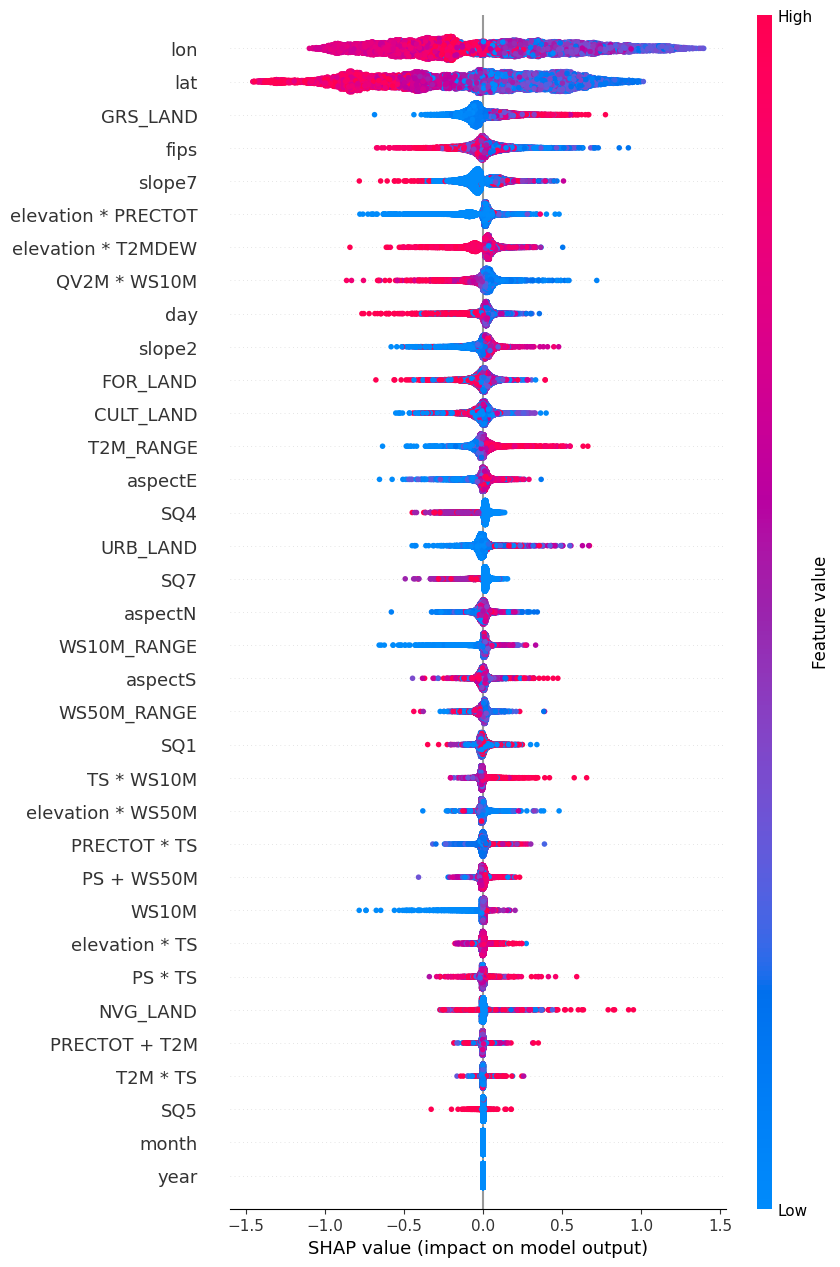

In [35]:
# Graficar el beeswarm plot con todas las variables
shap.plots.beeswarm(shap_values, max_display=X_test_30_days.shape[1])

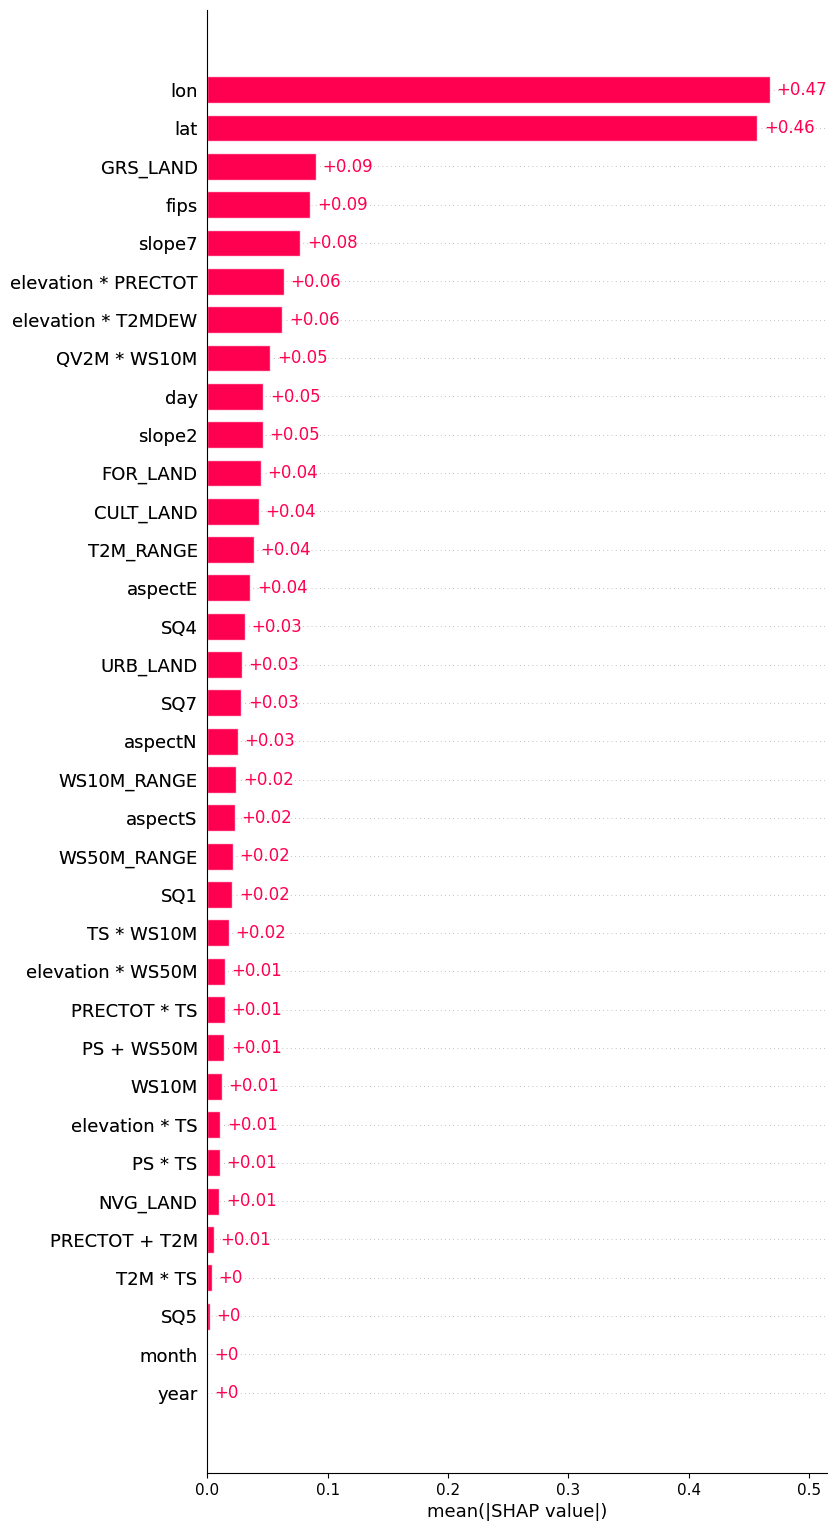

In [36]:
# Graficar el bar plot con todas las variables
shap.plots.bar(shap_values, max_display=X_test_30_days.shape[1])

In [38]:
# Ordenar por 'fips' y 'date' para garantizar que los registros estén en orden temporal
X_test_sorted = X_test.sort_values(by=['fips', 'date'])

# Filtrar solo los próximos 7 días por cada sitio 'fips'
X_test_7_days = X_test_sorted.groupby('fips').head(7)

# Separar las características y el target de nuevo
y_test_7_days = X_test_7_days['score_final_interpolated']
X_test_7_days = X_test_7_days.drop(columns=['score_final_interpolated', 'date'])  # Eliminamos también la columna 'date'

# Predecir solo para los próximos 7 días por cada sitio
y_pred_7_days = lgbm_best.predict(X_test_7_days)
y_prob_7_days = lgbm_best.predict_proba(X_test_7_days)

In [39]:
# Imprimir los resultados
print("Predicciones para los próximos 7 días por cada sitio:")
print(y_pred_7_days)

In [40]:
# También puedes evaluar el modelo en esos 7 días por sitio
print("Reporte de clasificación para los próximos 7 días por sitio:")
print(classification_report(y_test_7_days, y_pred_7_days))

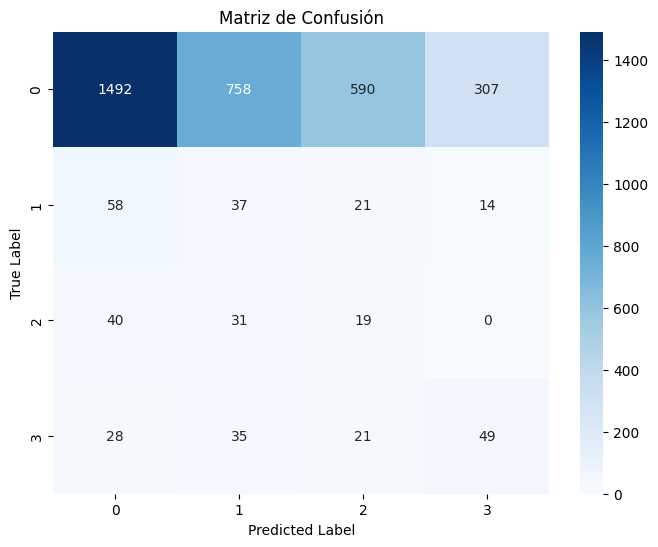

In [41]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test_7_days, y_pred_7_days)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

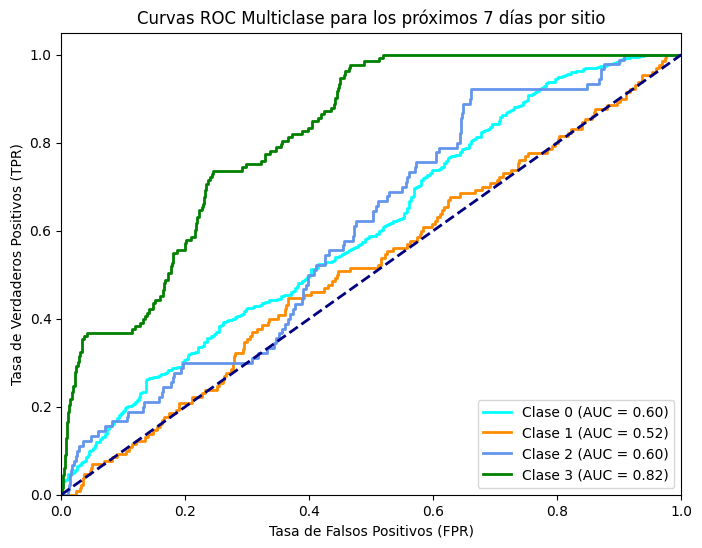

In [42]:
# Binarizar las etiquetas de prueba para calcular la curva ROC multiclase
n_classes = len(np.unique(y_test_7_days))  # Número de clases
y_test_bin = label_binarize(y_test_7_days, classes=np.arange(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular curvas ROC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob_7_days[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC para cada clase
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'purple', 'red']  # Asignar colores a cada clase

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

# Gráfica ROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC Multiclase para los próximos 7 días por sitio')
plt.legend(loc="lower right")
plt.show()

In [43]:
# Guardar el modelo completo en un archivo binario
joblib.dump(lgbm_best, 'models/lightgbm_model_6.pkl')
logging.info("Modelo guardado en 'models/lightgbm_model_6.pkl'.")